# MPI

In [4]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from utils.mpi_utils import *
import math
import matplotlib.ticker as mtick

def py_dir(filename):
    return "./MST_O_logn_logn/" + filename 
    
def cpp_dir(filename):
    return "./MST_O_logn_logn_C-/csvs/" + filename

def cuda_dir(filename):
    return "./MST_O_logn_logn_Cuda/csvs/" + filename 

In [5]:
def n_edges(n):
    return n * (n - 1) / 2

def graph_size_scale(n, factor):
    return n_edges(n * factor) / n_edges(n)
# [1,
#  4.285714285714286,
#  17.714285714285715,
#  72.0,
#  290.2857142857143,
#  1165.7142857142858,
#  4672.0,
#  18706.285714285714,
#  74861.71428571429,
#  299520.0]
# It scales roughly 4 times
# t size of the result array
def scale_array(factor, start_n, t):
    result = [1]
    n = start_n
    for i in range(t - 1):
        result.append(graph_size_scale(n, factor) * result[-1])
        n *= factor
    return result 

In [6]:
scale_array(2, 8, 10)

[1,
 4.285714285714286,
 17.714285714285715,
 72.0,
 290.2857142857143,
 1165.7142857142858,
 4672.0,
 18706.285714285714,
 74861.71428571429,
 299520.0]

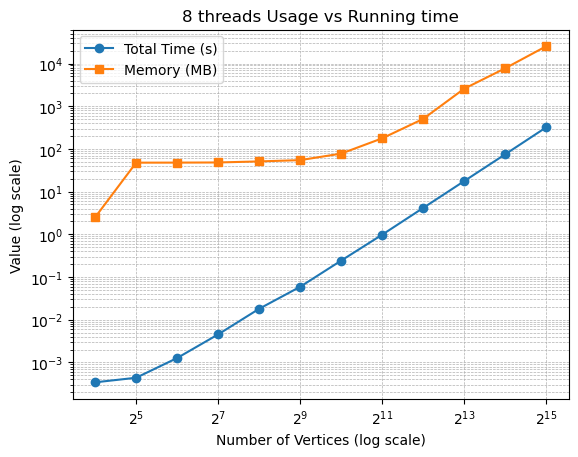

In [39]:
df = pd.read_csv(cpp_dir('n1_t8_composition.csv'))

data = df[["num_vertices", "t_total", "mem"]]

# Plotting
# plt.figure(figsize=(10, 6))

# Plot t_total(s)
plt.plot(data["num_vertices"], data["t_total"], marker='o', label='Total Time (s)')

# Plot mem(MB)
plt.plot(data["num_vertices"], data["mem"], marker='s', label='Memory (MB)')

# Log scale for better visualization
plt.xscale('log', base=2)
plt.yscale('log')

# Labels and title
plt.xlabel('Number of Vertices (log scale)')
plt.ylabel('Value (log scale)')
plt.title('8 threads Usage vs Running time')
plt.legend()
plt.grid(True, which="both", linestyle='--', linewidth=0.5)

# Save the plot
plt.savefig('figs/time_mem_n1_t8.pdf', format="pdf", bbox_inches="tight")
plt.show()


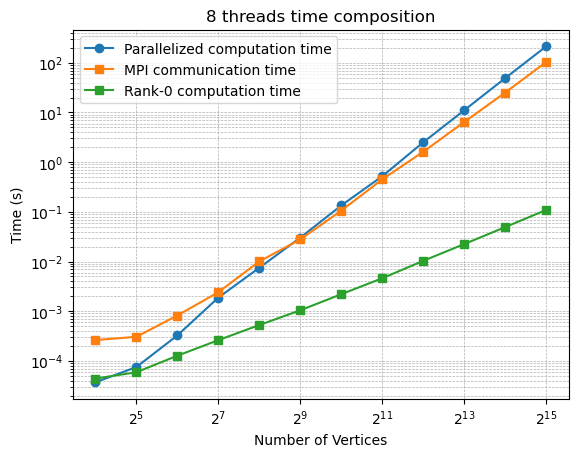

In [12]:
df = pd.read_csv(cpp_dir('n1_t8_composition.csv'))

# Plotting
# plt.figure(figsize=(10, 6))

plt.plot(data["num_vertices"], df["t_total"] - df["t_rank0"] - df["t_mpi"], marker='o', label='Parallelized computation time')
plt.plot(data["num_vertices"], df["t_mpi"], marker='s', label='MPI communication time')
plt.plot(data["num_vertices"], df["t_rank0"], marker='s', label='Rank-0 computation time')

# Log scale for better visualization
plt.xscale('log', base=2)
plt.yscale('log')

# Labels and title
plt.xlabel('Number of Vertices')
plt.ylabel('Time (s)')
plt.title('8 threads time composition')
plt.legend()
plt.grid(True, which="both", linestyle='--', linewidth=0.5)

# Save the plot
plt.savefig('figs/time_n1_t8_composition_time.pdf', format="pdf", bbox_inches="tight")
plt.show()


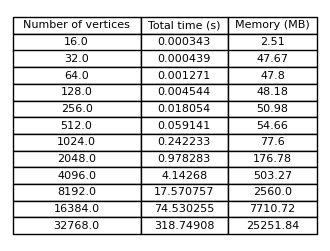

In [40]:
df = pd.read_csv(cpp_dir('n1_t8_composition.csv'))

data = df[["num_vertices", "t_total", "mem"]]

# Plotting
fig, ax = plt.subplots(figsize=(4, 3))
ax.axis('tight')
ax.axis('off')

table = ax.table(cellText=data.values, colLabels=["Number of vertices", "Total time (s)", "Memory (MB)"], loc='center', cellLoc='center')

# Style adjustments
table.auto_set_font_size(False)
table.set_fontsize(8)
table.auto_set_column_width(col=list(range(len(data.columns))))

# Save the table as an image
plt.savefig("figs/time_mem_n1_t8_table.pdf")
plt.show()


In [14]:
def format_log(numbers):
    """
    Takes an iterable of integers and returns an array of LaTeX-formatted logarithms.

    Parameters:
        numbers (iterable of int): Iterable containing integers to compute the logarithm for.

    Returns:
        list of str: LaTeX-formatted strings representing the logarithms.
    """
    latex_logs = []
    for num in numbers:
        if num <= 0:
            raise ValueError(f"Logarithm undefined for non-positive number: {num}")
        log_value = math.log(num, 2)
        latex_logs.append(rf'$2^{{{int(log_value)}}}$')
    return latex_logs

In [15]:
def plot_composition(_dir, title, file):
    df = pd.read_csv(_dir)

    width = 0.5

    fig, ax = plt.subplots()

    t_parallel = df['t_total'] - df['t_mpi'] - df['t_rank0']
    mpi_fractions = df['t_mpi'] / df['t_total']
    rank0_fractions = df['t_rank0'] / df['t_total']
    parallel_fractions = t_parallel / df['t_total']

    x = df["num_vertices"].astype(str)

    p = ax.bar(x, mpi_fractions, width, label="MPI communication time")
    p = ax.bar(x, parallel_fractions, width, label="Parallelized computation time", bottom=mpi_fractions)
    p = ax.bar(x, rank0_fractions, width, label="Rank-0 computation time", bottom=mpi_fractions + parallel_fractions)

    ax.set_title(title)
    ax.legend(loc="upper right")
    plt.xlabel('Number of Vertices')
    plt.ylabel('Composition (percentage)')
    plt.xticks(
        ticks=x,
        labels=format_log(df["num_vertices"]),
    )
    plt.grid(True, which="major", linestyle='--', linewidth=0.5)
    ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))

    plt.savefig(file, format="pdf", bbox_inches="tight")

In [16]:
def plot_strong_scaling_composition(n_v):
    df = pd.read_csv(cpp_dir(f'strong_scale_{n_v}.csv'))

    width = 0.5

    fig, ax = plt.subplots()

    t_parallel = df['t_total'] - df['t_mpi'] - df['t_rank0']
    mpi_fractions = df['t_mpi'] / df['t_total']
    rank0_fractions = df['t_rank0'] / df['t_total']
    parallel_fractions = t_parallel / df['t_total']

    x = df['num_threads'].astype('string')

    p = ax.bar(x, mpi_fractions, width, label="MPI communication time")
    p = ax.bar(x, parallel_fractions, width, label="Parallelized computation time", bottom=mpi_fractions)
    p = ax.bar(x, rank0_fractions, width, label="Rank-0 computation time", bottom=mpi_fractions + parallel_fractions)

    ax.set_title(f"MST_loglogn strong scaling time composition ({n_v} vertices)")
    ax.legend(loc="upper right")
    plt.xlabel('Number of Threads')
    plt.ylabel('Composition (percentage)')
    plt.xticks(
        ticks=x,
        labels=format_log(df['num_threads']),
    )
    plt.grid(True, which="major", linestyle='--', linewidth=0.5)
    ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))


    plt.savefig(f'figs/strong_scale_{n_v}_composition.pdf', format="pdf", bbox_inches="tight")

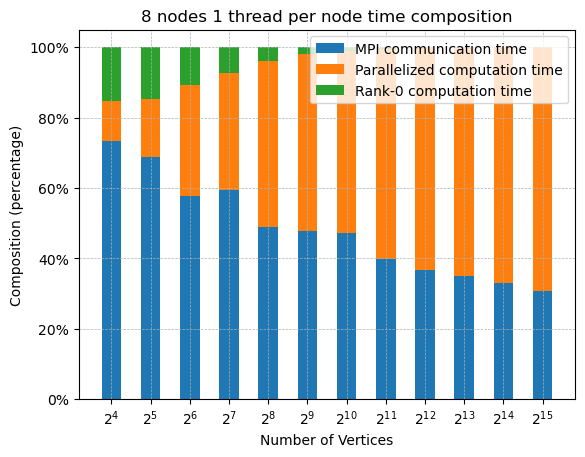

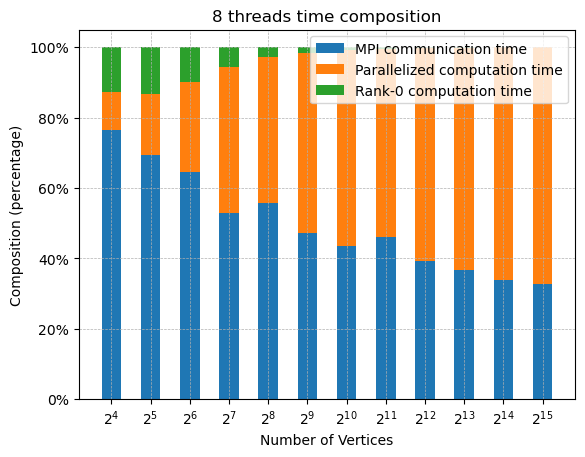

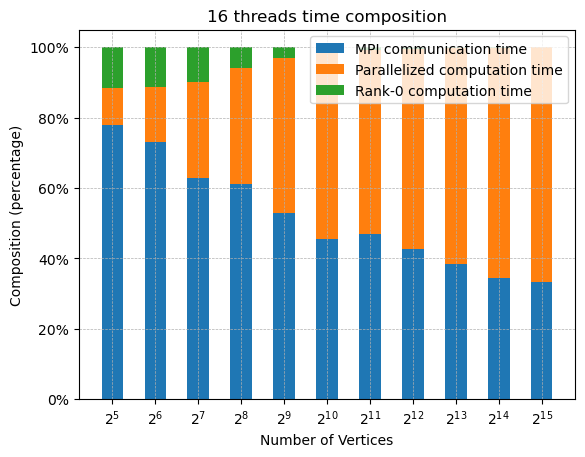

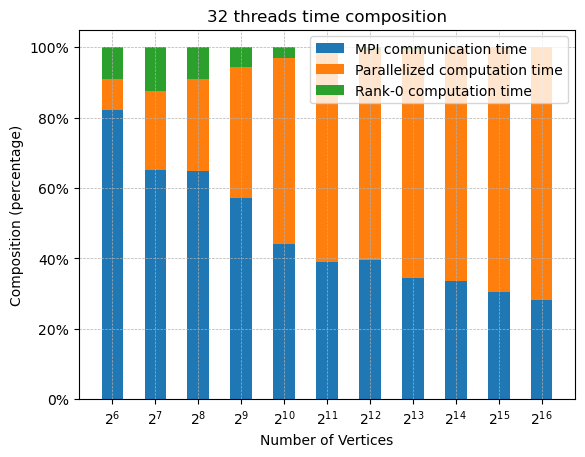

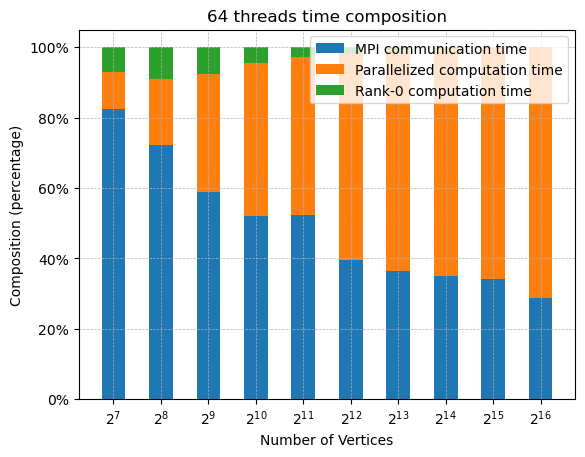

In [17]:
# TODO time grow
# 8 threads 16 G
plot_composition(
    _dir=cpp_dir('n8_t1_composition.csv'),
    title="8 nodes 1 thread per node time composition",
    file='figs/mpi_composition_n8_t1.pdf'
)

plot_composition(
    _dir=cpp_dir('n1_t8_composition.csv'),
    title="8 threads time composition",
    file='figs/mpi_composition_n1_t8.pdf'
)

# 16 tasks
plot_composition(
    _dir=cpp_dir('n1_t16_composition.csv'),
    title="16 threads time composition",
    file='figs/mpi_composition_n1_t16.pdf'
)

# 32 tasks
plot_composition(
    _dir=cpp_dir('n2_t16_composition.csv'),
    title="32 threads time composition",
    file='figs/mpi_composition_n2_t16.pdf'
)

# 64 tasks
plot_composition(
    _dir=cpp_dir('n4_t16_composition.csv'),
    title="64 threads time composition",
    file='figs/mpi_composition_n4_t16.pdf'
)

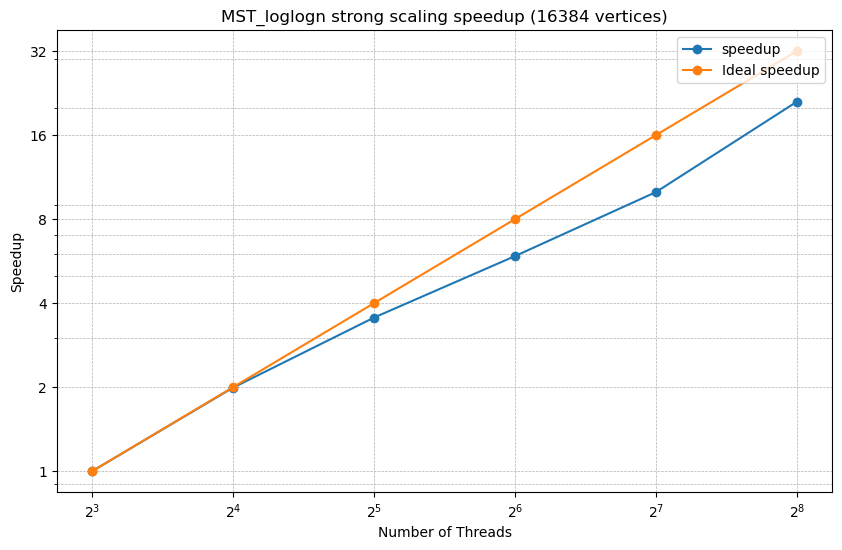

In [18]:
total = 16384
df = pd.read_csv(cpp_dir(f'strong_scale_{total}.csv'))

x = df['num_threads'].astype('string')
ideal_speedup = [2**i for i in range(len(df['t_mpi']))]

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(x, df['speed_up'], label="speedup", marker='o')
plt.plot(x, ideal_speedup, label="Ideal speedup", marker='o')

plt.legend(loc="upper right")
plt.title(f"MST_loglogn strong scaling speedup ({total} vertices)")
plt.xlabel('Number of Threads')
plt.ylabel('Speedup')

y = [str(i) for i in ideal_speedup]
plt.yscale('log')

plt.yticks(
    ticks=ideal_speedup,
    labels=y,
)
plt.xticks(
    ticks=x,
    labels=format_log(df['num_threads']),
)
plt.grid(True, which="both", linestyle='--', linewidth=0.5)


plt.savefig(f'figs/strong_scale_{total}_speedup.pdf', format="pdf", bbox_inches="tight")


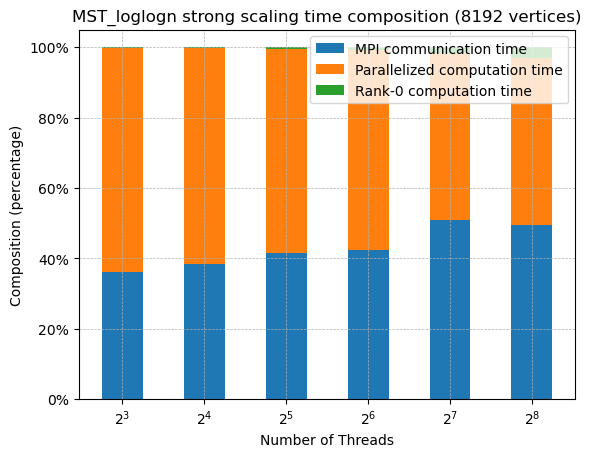

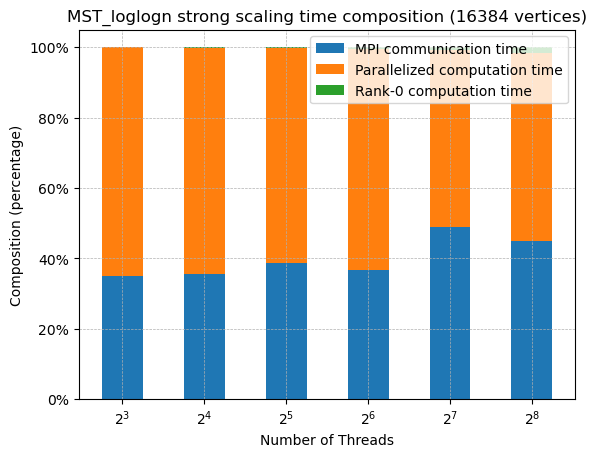

In [19]:
plot_strong_scaling_composition(8192)
plot_strong_scaling_composition(16384)


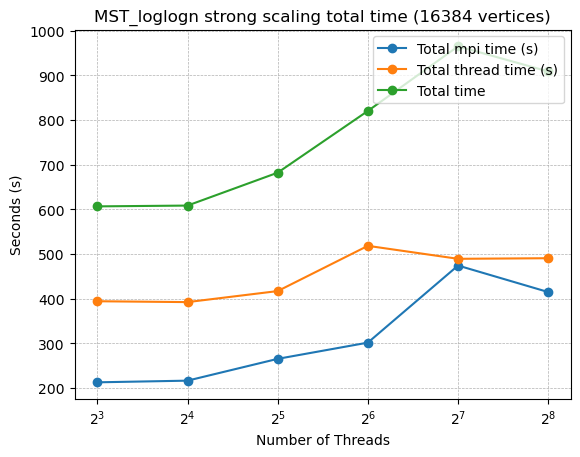

In [20]:
total=16384

df = pd.read_csv(cpp_dir(f'strong_scale_{total}.csv'))

width = 0.5

fig, ax = plt.subplots()
df['t_thread'] = df['t_total'] - df['t_mpi'] - df['t_rank0']

x = df['num_threads'].astype('string')
total_time = [int(x[i]) * (df['t_total'][i] - df['t_rank0'][0]) for i in range(len(x))]
total_mpi_time = [int(x[i]) * df['t_mpi'][i] for i in range(len(x))]
total_rank0_time = [int(x[i]) * df['t_thread'][i] for i in range(len(x))]

plt.plot(x, total_mpi_time, label="Total mpi time (s)", marker='o')
plt.plot(x, total_rank0_time, label="Total thread time (s)", marker='o')
plt.plot(x, total_time, label="Total time", marker='o')

ax.set_title(f"MST_loglogn strong scaling total time ({total} vertices)")
ax.legend(loc="upper right")
plt.xlabel('Number of Threads')
plt.ylabel('Seconds (s)')
plt.xticks(
    ticks=x,
    labels=format_log(df['num_threads']),
)
plt.grid(True, which="both", linestyle='--', linewidth=0.5)


plt.savefig(f'figs/strong_scale_{total}_total_time.pdf', format="pdf", bbox_inches="tight")

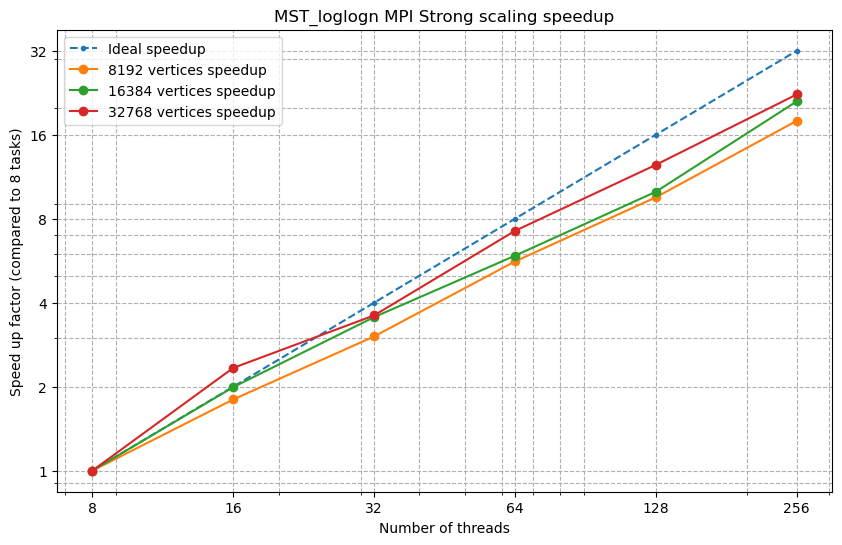

In [21]:
df_8192 = pd.read_csv(cpp_dir('strong_scale_8192.csv'))
df_16384 = pd.read_csv(cpp_dir('strong_scale_16384.csv'))
df_32768 = pd.read_csv(cpp_dir('strong_scale_32768.csv'))

x = df_32768["num_threads"]
# 8, 16, 32, ..., 128, 256

ideal_speedup = [2**i for i in range(len(df_8192['t_mpi']))]

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(x, ideal_speedup, label='Ideal speedup', marker='.', linestyle="--")
plt.plot(x, get_strong_scaling_speed_up(df_8192['t_total']), label='8192 vertices speedup', marker='o')
plt.plot(x, get_strong_scaling_speed_up(df_16384['t_total']), label='16384 vertices speedup', marker='o')
plt.plot(x, get_strong_scaling_speed_up(df_32768['t_total']), label='32768 vertices speedup', marker='o')

plt.xlabel('Number of threads')
plt.ylabel('Speed up factor (compared to 8 tasks)')
plt.title('MST_loglogn MPI Strong scaling speedup')
plt.xscale('log')
plt.yscale('log')

plt.legend()
plt.grid(True, which="both", ls="--")

plt.xticks(x, x)
plt.yticks(ideal_speedup, ideal_speedup)

plt.savefig('figs/mpi_cpp_strong_scaling.pdf', format="pdf", bbox_inches="tight")
plt.show()

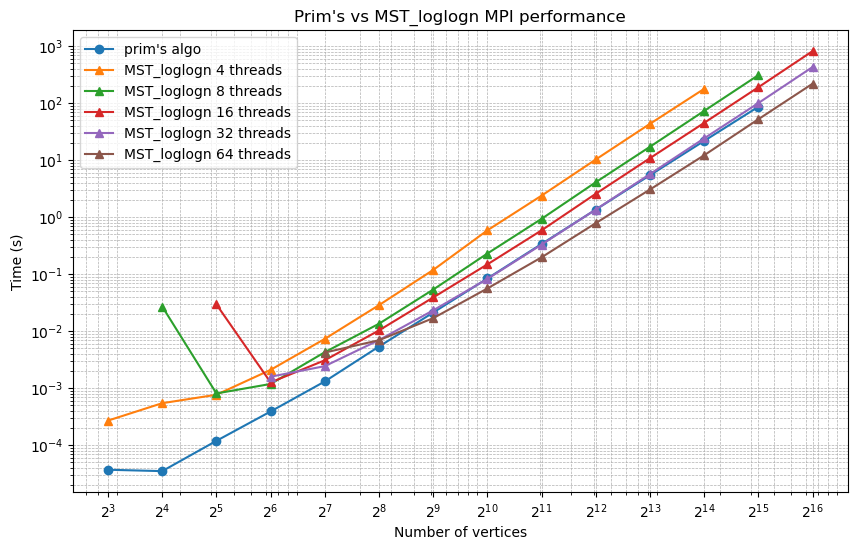

In [43]:
df_prim_py = pd.read_csv(cpp_dir('prim.csv'))

df_mpi_4_py = pd.read_csv(cpp_dir('dist_n1_t4.csv'))
df_mpi_8_py = pd.read_csv(cpp_dir('dist_n1_t8.csv'))
df_mpi_16_py = pd.read_csv(cpp_dir('dist_n1_t16.csv'))
df_mpi_32_py = pd.read_csv(cpp_dir('dist_n2_t16.csv'))
df_mpi_64_py = pd.read_csv(cpp_dir('dist_n4_t16.csv'))

ticks = [8]
while ticks[-1] <2 ** 16:
    ticks.append(ticks[-1] * 2)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(df_prim_py['num_vertices'], df_prim_py['t_prim'], label="prim's algo", marker='o')
plt.plot(df_mpi_4_py['num_vertices'], df_mpi_4_py['t_mpi'], label="MST_loglogn 4 threads", marker='^')
plt.plot(df_mpi_8_py['num_vertices'], df_mpi_8_py['t_mpi'], label="MST_loglogn 8 threads", marker='^')
plt.plot(df_mpi_16_py['num_vertices'], df_mpi_16_py['t_mpi'], label="MST_loglogn 16 threads", marker='^')
plt.plot(df_mpi_32_py['num_vertices'], df_mpi_32_py['t_mpi'], label="MST_loglogn 32 threads", marker='^')
plt.plot(df_mpi_64_py['num_vertices'], df_mpi_64_py['t_mpi'], label="MST_loglogn 64 threads", marker='^')

plt.xlabel('Number of vertices')
plt.ylabel('Time (s)')
plt.title("Prim's vs MST_loglogn MPI performance")
plt.legend()

plt.xscale('log')
plt.yscale('log')

plt.xticks((ticks), format_log(ticks))

plt.grid(True, which="both", ls="--", linewidth=0.5)
plt.savefig("figs/prim's_vs_MST_loglogn_single_thread.pdf", format="pdf", bbox_inches="tight")


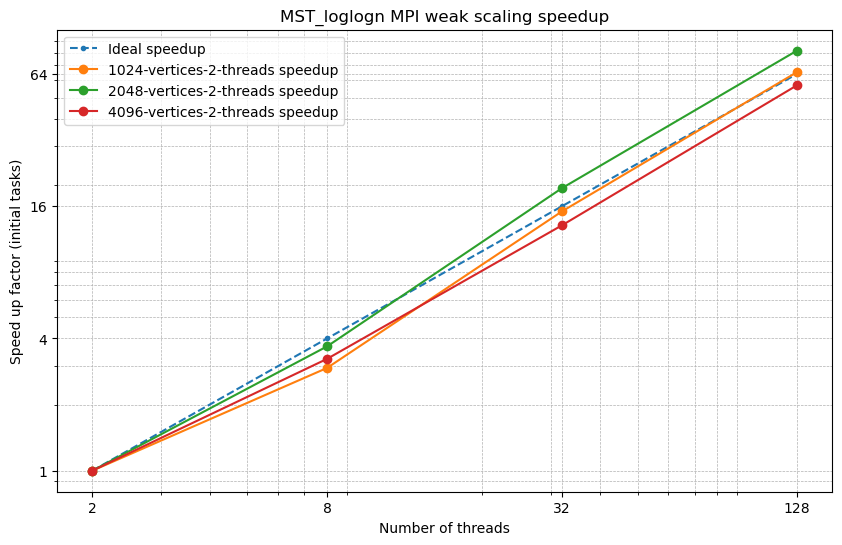

In [23]:
df_weak_1024 = pd.read_csv(cpp_dir('weak_scale_1024.csv'))
df_weak_2048 = pd.read_csv(cpp_dir('weak_scale_2048.csv'))
df_weak_4096 = pd.read_csv(cpp_dir('weak_scale_4096.csv'))

speedup_1024 = get_weak_scaling_speedup(df_weak_1024)
speedup_2048 = get_weak_scaling_speedup(df_weak_2048)
speedup_4096 = get_weak_scaling_speedup(df_weak_4096)

x = df_weak_1024["num_threads"]
# 8, 16, 32, ..., 128, 256

ideal_speedup = [4**i for i in range(len(df_weak_1024['t_mpi']))]

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(x, ideal_speedup, label='Ideal speedup', marker='.', linestyle="--")
plt.plot(x, speedup_1024, label='1024-vertices-2-threads speedup', marker='o')
plt.plot(x, speedup_2048, label='2048-vertices-2-threads speedup', marker='o')
plt.plot(x, speedup_4096, label='4096-vertices-2-threads speedup', marker='o')

plt.xlabel('Number of threads')
plt.ylabel('Speed up factor (initial tasks)')
plt.title('MST_loglogn MPI weak scaling speedup')

plt.xscale('log')
plt.yscale('log')

plt.legend()
plt.grid(True, which="both", ls="--", linewidth=0.5)

plt.xticks(x, x)
plt.yticks(ideal_speedup, ideal_speedup)

plt.savefig('figs/mpi_cpp_weak_scaling.pdf', format="pdf", bbox_inches="tight")


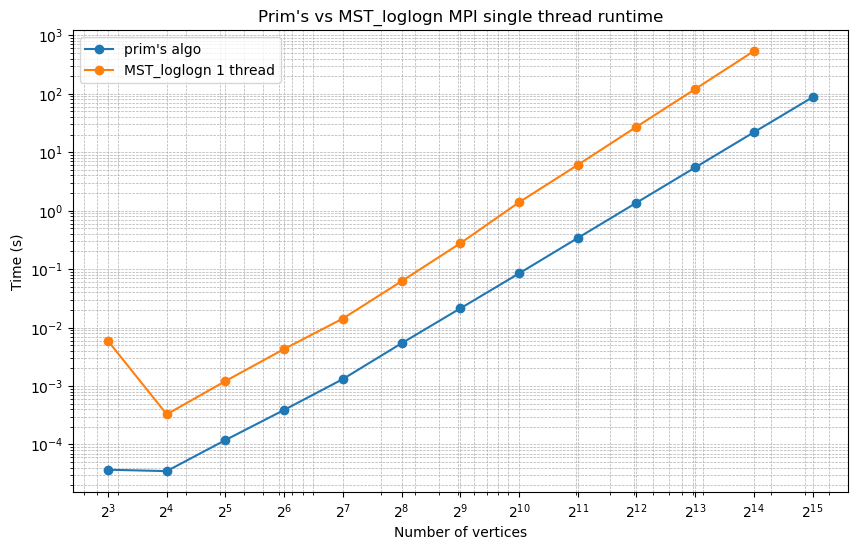

In [45]:
df_prim = pd.read_csv(cpp_dir('prim.csv'))

df_mpi_1 = pd.read_csv(cpp_dir('n1_t1.csv'))

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(df_prim['num_vertices'], df_prim['t_prim'], label="prim's algo", marker='o')
plt.plot(df_mpi_1['num_vertices'], df_mpi_1['t_total'], label="MST_loglogn 1 thread", marker='o')

plt.xlabel('Number of vertices')
plt.ylabel('Time (s)')
plt.title("Prim's vs MST_loglogn MPI single thread runtime")
plt.legend()

plt.xscale('log')
plt.yscale('log')
plt.xticks(df_prim['num_vertices'], format_log(df_prim['num_vertices']))

plt.grid(True, which="both", ls="--", linewidth=0.5)
plt.savefig("figs/prim's_vs_MST_loglogn.pdf", format="pdf", bbox_inches="tight")


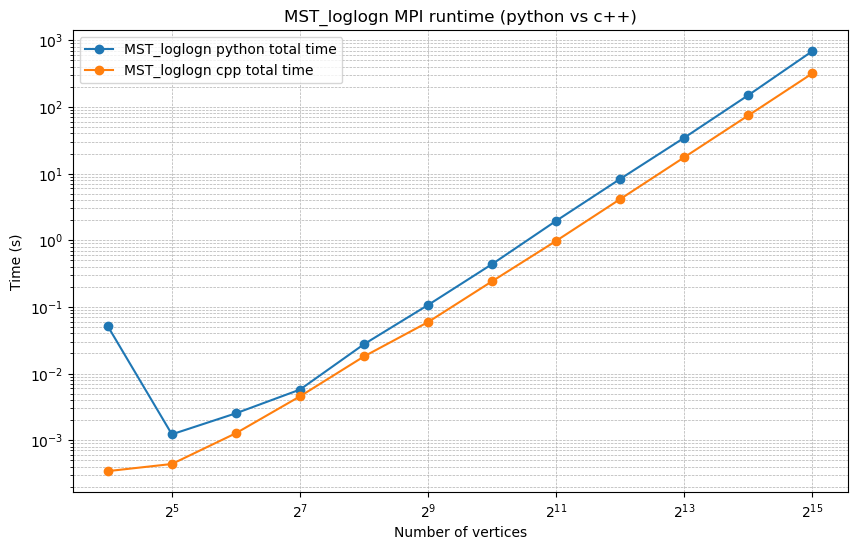

In [25]:
df_py = pd.read_csv(py_dir('dist_n1_t8_double.csv'))

df_cpp = pd.read_csv(cpp_dir('n1_t8_composition.csv'))

x = df_py["num_vertices"]

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(x, df_py['t_total'], label='MST_loglogn python total time', marker='o')
# plt.plot(x, df_py['t_mpi'], label='MST_loglogn python mpi time', marker='o')
# plt.plot(x, df_py['t_rank0'], label='MST_loglogn python rank0 time', marker='o')
# plt.plot(x, df_py['t_parallel'], label='MST_loglogn python parallel time', marker='o')

plt.plot(x, df_cpp['t_total'], label='MST_loglogn cpp total time', marker='o')
# plt.plot(x, df_cpp['t_mpi'], label='MST_loglogn cpp mpi time', marker='o')
# plt.plot(x, df_cpp['t_rank0'], label='MST_loglogn cpp rank0 time', marker='o')
# plt.plot(x, df_cpp['t_parallel'], label='MST_loglogn cpp parallel time', marker='o')
plt.xscale('log', base=2)
plt.yscale('log')
plt.grid(True, which="both", linestyle='--', linewidth=0.5)

plt.xlabel('Number of vertices')
plt.ylabel('Time (s)')
plt.title("MST_loglogn MPI runtime (python vs c++)")
plt.legend()
plt.savefig("figs/n1_t8_cpp_vs_python_total.pdf", format="pdf", bbox_inches="tight")

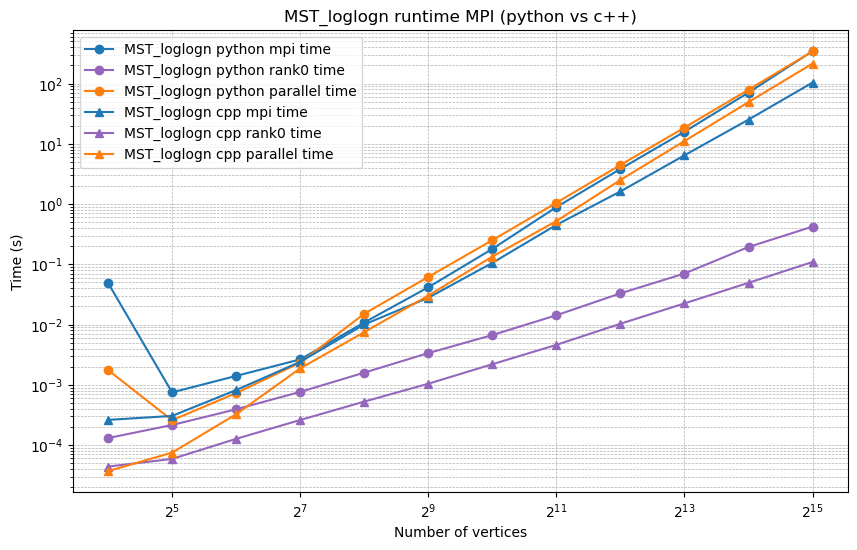

In [26]:
df_py = pd.read_csv(py_dir('dist_n1_t8_double.csv'))
df_cpp = pd.read_csv(cpp_dir('n1_t8_composition.csv'))

x = df_py["num_vertices"]

py_parallel = df_py['t_total'] - df_py['t_mpi'] - df_py['t_rank0']
cpp_parallel = df_cpp['t_total'] - df_cpp['t_mpi'] - df_cpp['t_rank0']

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(x, df_py['t_mpi'], label='MST_loglogn python mpi time', marker='o', color="#1f77b4")
plt.plot(x, df_py['t_rank0'], label='MST_loglogn python rank0 time', marker='o', color="#9467bd")
plt.plot(x, py_parallel, label='MST_loglogn python parallel time', marker='o', color="#ff7f0e")

plt.plot(x, df_cpp['t_mpi'], label='MST_loglogn cpp mpi time', marker='^', color="#1f77b4")
plt.plot(x, df_cpp['t_rank0'], label='MST_loglogn cpp rank0 time', marker='^', color="#9467bd")
plt.plot(x, cpp_parallel, label='MST_loglogn cpp parallel time', marker='^', color="#ff7f0e")
plt.xscale('log', base=2)
plt.yscale('log')
plt.grid(True, which="both", linestyle='--', linewidth=0.5)

plt.xlabel('Number of vertices')
plt.ylabel('Time (s)')
plt.title("MST_loglogn runtime MPI (python vs c++)")
plt.legend()
plt.savefig("figs/n1_t8_cpp_vs_python_composition.pdf", format="pdf", bbox_inches="tight")

Try to answer:
* Reason behind each fraction's time portion, trend
* How is this related to Congested clique.

In [27]:
def plot_composition(_dir, title, file):
    df = pd.read_csv(_dir)

    width = 0.5

    fig, ax = plt.subplots()

    t_parallel = df['t_total'] - df['t_mpi'] - df['t_rank0']
    mpi_fractions = df['t_mpi'] / df['t_total']
    rank0_fractions = df['t_rank0'] / df['t_total']
    parallel_fractions = t_parallel / df['t_total']

    x = df["num_vertices"].astype(str)

    p = ax.bar(x, mpi_fractions, width, label="MPI communication time")
    p = ax.bar(x, parallel_fractions, width, label="Parallelized computation time", bottom=mpi_fractions)
    p = ax.bar(x, rank0_fractions, width, label="Rank-0 computation time", bottom=mpi_fractions + parallel_fractions)

    ax.set_title(title)
    ax.legend(loc="upper right")
    plt.xlabel('Number of Vertices')
    plt.ylabel('Composition (percentage)')
    plt.xticks(
        ticks=x,
        labels=format_log(df["num_vertices"]),
    )
    plt.grid(True, which="major", linestyle='--', linewidth=0.5)
    ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))

    plt.savefig(file, format="pdf", bbox_inches="tight")

In [28]:
def df_cuda_time_category(df):
    df["t_cuda"] = df["t_min_from_cluster_kernel"] + df["t_min_to_cluster_kernel"] + df["t_speed_up_kernel"]
    df["t_mem"] = df["t_DtoH"] + df["t_HtoD"]

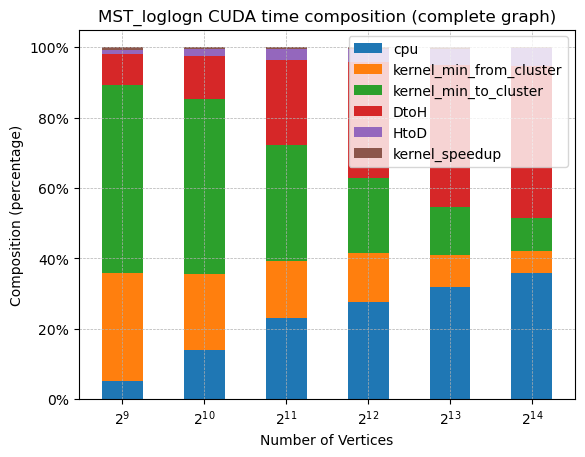

In [29]:
df = pd.read_csv(cuda_dir('complete_composition.csv'))

width = 0.5

fig, ax = plt.subplots()

total = df['t_total']

cpu_fractions = df['t_cpu'] / total
min_from_cluster_fractions = df['t_min_from_cluster_kernel'] / total
min_to_cluster_fractions = df['t_min_to_cluster_kernel'] / total
speedup_fractions = df['t_speed_up_kernel'] / total
DtoH_fractions = df['t_DtoH'] / total
HtoD_fractions = df['t_HtoD'] / total



fractions = [cpu_fractions, min_from_cluster_fractions, min_to_cluster_fractions, DtoH_fractions, HtoD_fractions, speedup_fractions] 
fractions_name = ["cpu", "kernel_min_from_cluster", "kernel_min_to_cluster", "DtoH", "HtoD", "kernel_speedup"]
x = tuple([str(i) for i in df['num_vertices']])

# Draw bar
for i in range(len(fractions)):
    if i == 0:
        ax.bar(x, fractions[i], width, label=fractions_name[i])
        fractions_sum = fractions[i]
    else:
        ax.bar(x, fractions[i], width, label=fractions_name[i], bottom=fractions_sum)
        fractions_sum += fractions[i]

ax.set_title("MST_loglogn CUDA time composition (complete graph)")
ax.legend(loc="upper right")
plt.xlabel('Number of Vertices')
plt.ylabel('Composition (percentage)')
plt.xticks(
    ticks=x,
    labels=format_log(df["num_vertices"]),
)
plt.grid(True, which="major", linestyle='--', linewidth=0.5)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))



plt.savefig('figs/cuda_composition_complete.pdf', format="pdf", bbox_inches="tight")


In [30]:
def cuda_time_to_second(df):
    cols = ["t_total", "t_cpu", "t_min_from_cluster_kernel", "t_min_to_cluster_kernel", "t_speed_up_kernel", "t_DtoH", "t_HtoD"]

    for col in cols:
        df[col] = df[col] / 1000

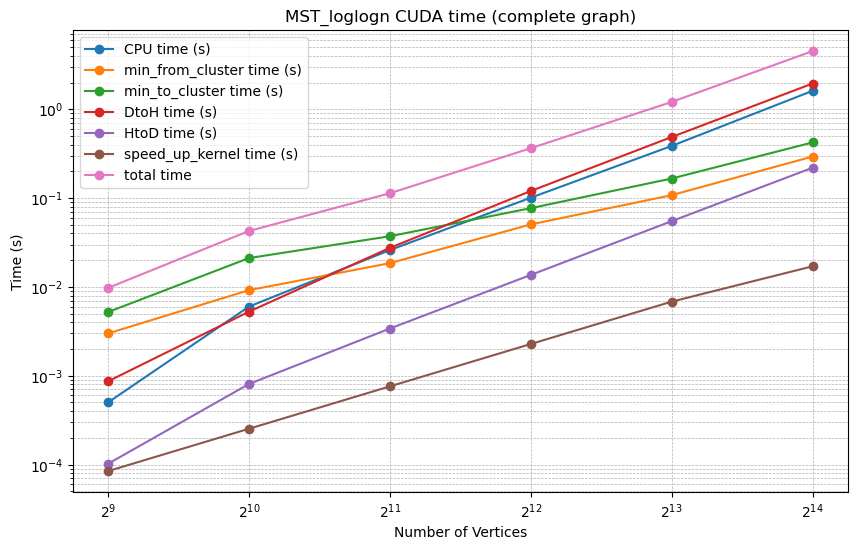

In [31]:
df = pd.read_csv(cuda_dir('complete_composition.csv'))

cuda_time_to_second(df)

# Plotting
plt.figure(figsize=(10, 6))
total = df['t_total']

plt.plot(df["num_vertices"], df['t_cpu'], marker='o', label='CPU time (s)')
plt.plot(df["num_vertices"], df['t_min_from_cluster_kernel'], marker='o', label='min_from_cluster time (s)')
plt.plot(df["num_vertices"], df['t_min_to_cluster_kernel'], marker='o', label='min_to_cluster time (s)')
plt.plot(df["num_vertices"], df["t_DtoH"], marker='o', label='DtoH time (s)')
plt.plot(df["num_vertices"], df["t_HtoD"], marker='o', label='HtoD time (s)')
plt.plot(df["num_vertices"], df["t_speed_up_kernel"], marker='o', label='speed_up_kernel time (s)')
plt.plot(df["num_vertices"], total, marker='o', label='total time')

# Log scale for better visualization
plt.xscale('log', base=2)
plt.yscale('log')

# Labels and title
plt.xlabel('Number of Vertices')
plt.ylabel('Time (s)')
plt.title('MST_loglogn CUDA time (complete graph)')
plt.legend()
plt.grid(True, which="both", linestyle='--', linewidth=0.5)

# Save the plot
plt.savefig('figs/cuda_composition_complete_time.pdf', format="pdf", bbox_inches="tight")
plt.show()


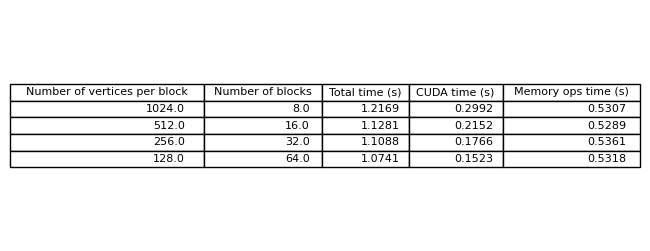

In [32]:
import pandas as pd
import matplotlib.pyplot as plt

# Read and process the data
df = pd.read_csv(cuda_dir('complete_composition_block_size.csv'))
cuda_time_to_second(df)
df_cuda_time_category(df)

df["n_block"] = 8192 / df["rank"]

# Select and format the columns
data = df[["rank", "n_block", "t_total", "t_cuda", "t_mem"]]
data = data.rename(columns={
    "rank": "Number of vertices per block",
    "n_block": "Number of blocks",
    "t_total": "Total time (s)",
    "t_cuda": "CUDA time (s)",
    "t_mem": "Memory ops time (s)"
})

# Convert and round the values
data["Number of vertices per block"] = data["Number of vertices per block"].astype(int)
data["Number of blocks"] = data["Number of blocks"].astype(int)
data["Total time (s)"] = data["Total time (s)"].round(4)
data["CUDA time (s)"] = data["CUDA time (s)"].round(4)
data["Memory ops time (s)"] = data["Memory ops time (s)"].round(4)

# Plotting
fig, ax = plt.subplots(figsize=(4, 3))
ax.axis('tight')
ax.axis('off')

table = ax.table(cellText=data.values, 
                 colLabels=data.columns,
                 loc='center')

# Style adjustments
table.auto_set_font_size(False)
table.set_fontsize(8)
table.auto_set_column_width(col=list(range(len(data.columns))))

# Save the table as an image
plt.savefig("figs/cuda_complete_varying_block_size_8192.pdf", bbox_inches='tight')
plt.show()

In [33]:
def cuda_total_time(df):
    return df['t_cpu'] + df['t_min_from_cluster_kernel'] + df['t_min_to_cluster_kernel'] + df['t_DtoH'] + df['t_HtoD']

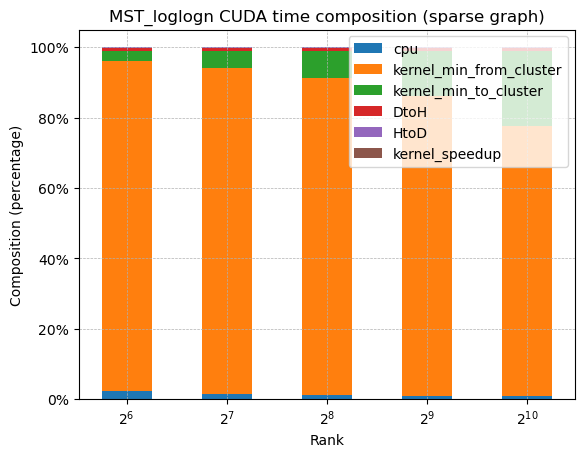

In [34]:
df = pd.read_csv(cuda_dir('sparse_composition_80_blocks.csv'))

width = 0.5

fig, ax = plt.subplots()

total = df['t_total']

cpu_fractions = df['t_cpu'] / total
min_from_cluster_fractions = df['t_min_from_cluster_kernel'] / total
min_to_cluster_fractions = df['t_min_to_cluster_kernel'] / total
speedup_fractions = df['t_speed_up_kernel'] / total
DtoH_fractions = df['t_DtoH'] / total
HtoD_fractions = df['t_HtoD'] / total


fractions = [cpu_fractions, min_from_cluster_fractions, min_to_cluster_fractions, DtoH_fractions, HtoD_fractions, speedup_fractions] 
fractions_name = ["cpu", "kernel_min_from_cluster", "kernel_min_to_cluster", "DtoH", "HtoD", "kernel_speedup"]
x = tuple([str(i) for i in df['rank']])

# Draw bar
for i in range(len(fractions)):
    if i == 0:
        ax.bar(x, fractions[i], width, label=fractions_name[i])
        fractions_sum = fractions[i]
    else:
        ax.bar(x, fractions[i], width, label=fractions_name[i], bottom=fractions_sum)
        fractions_sum += fractions[i]

ax.set_title("MST_loglogn CUDA time composition (sparse graph)")
ax.legend(loc="upper right")
plt.xlabel('Rank')
plt.ylabel('Composition (percentage)')
plt.xticks(
    ticks=x,
    labels=format_log(df["rank"]),
)
plt.grid(True, which="major", linestyle='--', linewidth=0.5)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))


plt.savefig('figs/cuda_composition_sparse_persistent.pdf', format="pdf", bbox_inches="tight")


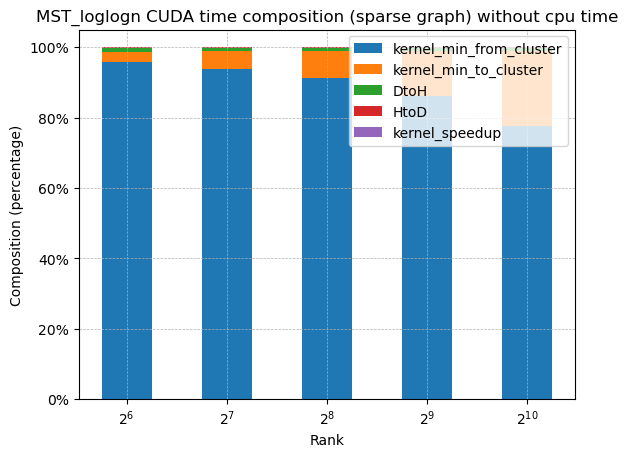

In [35]:
df = pd.read_csv(cuda_dir('sparse_composition_80_blocks.csv'))

width = 0.5

fig, ax = plt.subplots()

total = df['t_total'] - df['t_cpu']

min_from_cluster_fractions = df['t_min_from_cluster_kernel'] / total
min_to_cluster_fractions = df['t_min_to_cluster_kernel'] / total
speedup_fractions = df['t_speed_up_kernel'] / total
DtoH_fractions = df['t_DtoH'] / total
HtoD_fractions = df['t_HtoD'] / total


fractions = [min_from_cluster_fractions, min_to_cluster_fractions, DtoH_fractions, HtoD_fractions, speedup_fractions] 
fractions_name = ["kernel_min_from_cluster", "kernel_min_to_cluster", "DtoH", "HtoD", "kernel_speedup"]
x = tuple([str(i) for i in df['rank']])

# Draw bar
for i in range(len(fractions)):
    if i == 0:
        ax.bar(x, fractions[i], width, label=fractions_name[i])
        fractions_sum = fractions[i]
    else:
        ax.bar(x, fractions[i], width, label=fractions_name[i], bottom=fractions_sum)
        fractions_sum += fractions[i]

ax.set_title("MST_loglogn CUDA time composition (sparse graph) without cpu time")
ax.legend(loc="upper right")
plt.xlabel('Rank')
plt.ylabel('Composition (percentage)')
plt.xticks(
    ticks=x,
    labels=format_log(df["rank"]),
)
plt.grid(True, which="major", linestyle='--', linewidth=0.5)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))


plt.savefig('figs/cuda_composition_sparse_persistent_no_cpu.pdf', format="pdf", bbox_inches="tight")


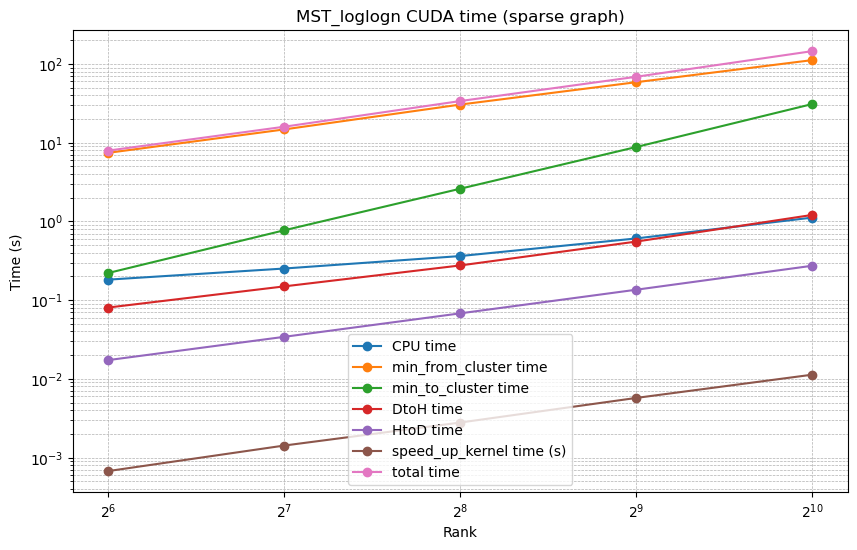

In [36]:
df = pd.read_csv(cuda_dir('sparse_composition_80_blocks.csv'))

cuda_time_to_second(df)
df_cuda_time_category(df)


# Plotting
plt.figure(figsize=(10, 6))
total = df['t_total']

plt.plot(df["rank"], df['t_cpu'], marker='o', label='CPU time')
plt.plot(df["rank"], df['t_min_from_cluster_kernel'], marker='o', label='min_from_cluster time')
plt.plot(df["rank"], df['t_min_to_cluster_kernel'], marker='o', label='min_to_cluster time')
plt.plot(df["rank"], df["t_DtoH"], marker='o', label='DtoH time')
plt.plot(df["rank"], df["t_HtoD"], marker='o', label='HtoD time')
plt.plot(df["rank"], df["t_speed_up_kernel"], marker='o', label='speed_up_kernel time (s)')
plt.plot(df["rank"], total, marker='o', label='total time')


# plt.plot(df["rank"], total, marker='o', label='total time')
# plt.plot(df["rank"], df['t_cpu'], marker='o', label='CPU time')
# plt.plot(df["rank"], df['t_cuda'], marker='o', label='CUDA time')
# plt.plot(df["rank"], df['t_mem'], marker='o', label='Memory ops time')

# Log scale for better visualization
plt.xscale('log', base=2)
plt.yscale('log')

# Labels and title
plt.xlabel('Rank')
plt.ylabel('Time (s)')
plt.title('MST_loglogn CUDA time (sparse graph)')
plt.legend()
plt.grid(True, which="both", linestyle='--', linewidth=0.5)

# Save the plot
plt.savefig('figs/cuda_composition_sparse_time.pdf', format="pdf", bbox_inches="tight")
plt.show()


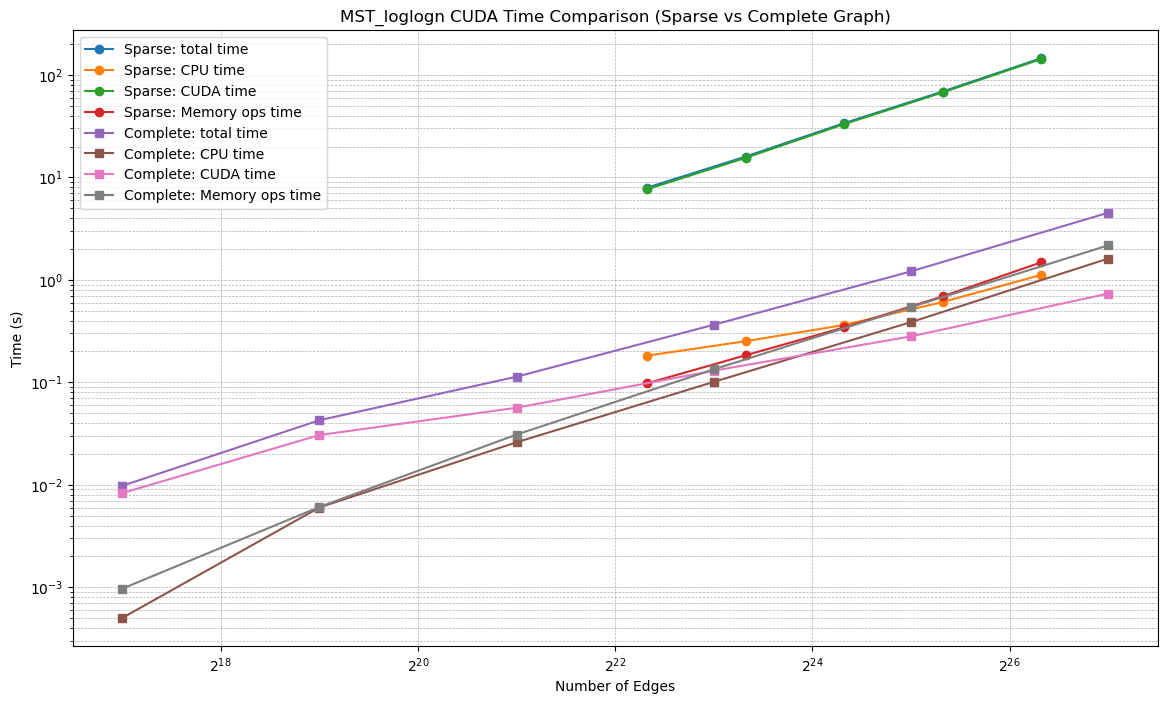

In [37]:
# Load sparse composition data
df_sparse = pd.read_csv(cuda_dir('sparse_composition_80_blocks.csv'))
cuda_time_to_second(df_sparse)
df_cuda_time_category(df_sparse)

# Calculate number of sparse edges
num_sparse_edge = 80 * 1024 * df_sparse["rank"]

# Load complete composition data
df_complete = pd.read_csv(cuda_dir('complete_composition.csv'))
cuda_time_to_second(df_complete)
df_cuda_time_category(df_complete)

# Calculate number of complete edges
num_complete_edges = (df_complete["num_vertices"] * (df_complete["num_vertices"] - 1)) / 2

# Plotting
plt.figure(figsize=(14, 8))

# Sparse graph plot
# plt.plot(num_sparse_edge, df_sparse['t_total'], marker='o', label='Sparse: total time')
# plt.plot(num_sparse_edge, df_sparse['t_cpu'], marker='o', label='Sparse: CPU time')
# plt.plot(num_sparse_edge, df_sparse['t_min_from_cluster_kernel'], marker='o', label='Sparse: min_from_cluster time')
# plt.plot(num_sparse_edge, df_sparse['t_min_to_cluster_kernel'], marker='o', label='Sparse: min_to_cluster time')
# plt.plot(num_sparse_edge, df_sparse['t_DtoH'], marker='o', label='Sparse: DtoH time')
# plt.plot(num_sparse_edge, df_sparse['t_HtoD'], marker='o', label='Sparse: HtoD time')

plt.plot(num_sparse_edge, df_sparse['t_total'], marker='o', label='Sparse: total time')
plt.plot(num_sparse_edge, df_sparse['t_cpu'], marker='o', label='Sparse: CPU time')
plt.plot(num_sparse_edge, df_sparse['t_cuda'], marker='o', label='Sparse: CUDA time')
plt.plot(num_sparse_edge, df_sparse['t_mem'], marker='o', label='Sparse: Memory ops time')


# Complete graph plot
# plt.plot(num_complete_edges, df_complete['t_total'], marker='s', label='Complete: total time')
# plt.plot(num_complete_edges, df_complete['t_cpu'], marker='s', label='Complete: CPU time')
# plt.plot(num_complete_edges, df_complete['t_min_from_cluster_kernel'], marker='s', label='Complete: min_from_cluster time')
# plt.plot(num_complete_edges, df_complete['t_min_to_cluster_kernel'], marker='s', label='Complete: min_to_cluster time')
# plt.plot(num_complete_edges, df_complete['t_speed_up_kernel'], marker='s', label='Complete: speed_up_kernel time')
# plt.plot(num_complete_edges, df_complete['t_DtoH'], marker='s', label='Complete: DtoH time')
# plt.plot(num_complete_edges, df_complete['t_HtoD'], marker='s', label='Complete: HtoD time')

plt.plot(num_complete_edges, df_complete['t_total'], marker='s', label='Complete: total time')
plt.plot(num_complete_edges, df_complete['t_cpu'], marker='s', label='Complete: CPU time')
plt.plot(num_complete_edges, df_complete['t_cuda'], marker='s', label='Complete: CUDA time')
plt.plot(num_complete_edges, df_complete['t_mem'], marker='s', label='Complete: Memory ops time')

# Log scale for better visualization
plt.xscale('log', base=2)
plt.yscale('log')

# Labels and title
plt.xlabel('Number of Edges')
plt.ylabel('Time (s)')
plt.title('MST_loglogn CUDA Time Comparison (Sparse vs Complete Graph)')
plt.legend()
plt.grid(True, which="both", linestyle='--', linewidth=0.5)

# Save the plot
plt.savefig('figs/cuda_composition_comparison.pdf', format="pdf", bbox_inches="tight")
plt.show()

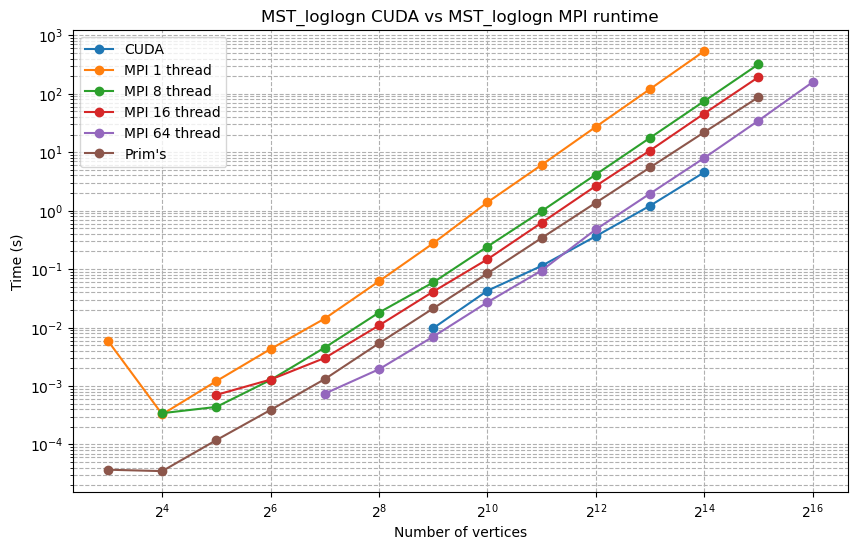

In [38]:
df_cuda = pd.read_csv(cuda_dir('complete_composition.csv'))

df_mpi_1 = pd.read_csv(cpp_dir('n1_t1.csv'))
df_mpi_8 = pd.read_csv(cpp_dir('n1_t8_composition.csv'))
df_mpi_16 = pd.read_csv(cpp_dir('n1_t16_composition.csv'))
df_mpi_64 = pd.read_csv(cpp_dir('dist_n4_t16.csv'))

df_prim = pd.read_csv(cpp_dir('prim.csv'))

# Plotting
plt.figure(figsize=(10, 6))
# CUDA time is in ms
plt.plot(df_cuda['num_vertices'], df_cuda['t_total']/1000, label="CUDA", marker='o')
plt.plot(df_mpi_1['num_vertices'], df_mpi_1['t_total'], label="MPI 1 thread", marker='o')
plt.plot(df_mpi_8['num_vertices'], df_mpi_8['t_total'], label="MPI 8 thread", marker='o')
plt.plot(df_mpi_16['num_vertices'], df_mpi_16['t_total'], label="MPI 16 thread", marker='o')
plt.plot(df_mpi_64['num_vertices'], df_mpi_64['t_mpi_local'], label="MPI 64 thread", marker='o')
plt.plot(df_prim['num_vertices'], df_prim['t_prim'], label="Prim's", marker='o')

plt.xlabel('Number of vertices')
plt.ylabel('Time (s)')
plt.title("MST_loglogn CUDA vs MST_loglogn MPI runtime")
plt.legend()

plt.xscale('log', base=2)
plt.yscale('log')

plt.grid(True, which="both", ls="--")
plt.savefig("figs/CUDA_vs_MPI.pdf", format="pdf", bbox_inches="tight")
